# Intro to Argovis' API

## Authors

 - Author1 = {"name": "William Mills", "affiliation": "Department of Atmospheric and Oceanic Sciences, University of Colorado Boulder, Boulder, CO, United States", "email": "William.Mills−1@colorado.edu", "orcid": "0000-0002-5887-6270"}
 - Author2 = {"name": "Donata Giglio", "affiliation": "Department of Atmospheric and Oceanic Sciences, University of Colorado Boulder, Boulder, CO, United States", "email": "donata.Giglio@colorado.edu", "orcid": "0000-0002-3738-4293"}
 - Author3 = {"name": "Megan Scanderbeg", "affiliation": "Scripps Institution of Oceanography", "email": "mscanderbeg@ucsd.edu", "orcid": "0000-0002-0398-7272"}
 - Author4 = {"name": "Tyler Tucker", "affiliation": "W. M. Keck Observatory", "email": "ttucker@keck.hawaii.edu", "orcid": "0000-0002-0560-9777"}

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro-to-Argovis'-API" data-toc-modified-id="Intro-to-Argovis'-API-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro to Argovis' API</a></span><ul class="toc-item"><li><span><a href="#Authors" data-toc-modified-id="Authors-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Authors</a></span></li><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Technical-contributions" data-toc-modified-id="Technical-contributions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Technical contributions</a></span></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Methodology</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Funding" data-toc-modified-id="Funding-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Funding</a></span></li><li><span><a href="#Keywords" data-toc-modified-id="Keywords-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Keywords</a></span></li><li><span><a href="#Citation" data-toc-modified-id="Citation-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Citation</a></span></li><li><span><a href="#Suggested-next-steps" data-toc-modified-id="Suggested-next-steps-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Suggested next steps</a></span></li><li><span><a href="#Acknowledgements" data-toc-modified-id="Acknowledgements-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Acknowledgements</a></span></li></ul></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Library-import" data-toc-modified-id="Library-import-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Library import</a></span></li><li><span><a href="#Local-library-import" data-toc-modified-id="Local-library-import-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Local library import</a></span></li></ul></li><li><span><a href="#Parameter-definitions" data-toc-modified-id="Parameter-definitions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parameter definitions</a></span></li><li><span><a href="#Data-import" data-toc-modified-id="Data-import-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data import</a></span></li><li><span><a href="#Data-processing-and-analysis" data-toc-modified-id="Data-processing-and-analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data processing and analysis</a></span><ul class="toc-item"><li><span><a href="#Co-location-examples" data-toc-modified-id="Co-location-examples-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Co-location examples</a></span><ul class="toc-item"><li><span><a href="#Data-source-searching-&amp;-negation-search" data-toc-modified-id="Data-source-searching-&amp;-negation-search-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Data source searching &amp; negation search</a></span></li><li><span><a href="#Searching-by-available-data" data-toc-modified-id="Searching-by-available-data-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Searching by available data</a></span></li><li><span><a href="#Proximity-search" data-toc-modified-id="Proximity-search-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Proximity search</a></span></li></ul></li><li><span><a href="#QC-filtering" data-toc-modified-id="QC-filtering-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>QC filtering</a></span></li><li><span><a href="#Interpolation" data-toc-modified-id="Interpolation-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Interpolation</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Purpose

The Argovis project (argovis.colorado.edu) is upgrading its API, with a new design that better supports expressive, targeted search across multiple data sources, including Argo floats, GO-SHIP profiles, and more. This new API is intended to enable co-location studies across datasets and efficiently scoped download of exactly the data researchers need. The purpose of this notebook is to illustrate some of the key features of this API as it is being developed; please note that this API is still under development and will evolve further before full release, and that helper functions here are examples only and will be superseded by a python library in future. Please send comments, feedback and feature requests to the team at argovis@colorado.edu.

## Technical contributions

 - API development to access point data in a new schema (e.g. oceanic profiles)
 - Alpha demo of the new Earth system data API, including:
   - Co-location and cross referencing of disparate data sources
   - Querying and downloading data subsets that contain exactly the measurements of interest, within the metadata space (lat / lon / time, data source, etc) of interest.

## Methodology

A new hierarchical JSON schema for describing generic Earth-system point data was developed in collaboration between Argo and GO-SHIP data experts, into which Argo, GO-SHIP, and tropical cyclone data were cast and indexed in Mongodb. This allows for convenient and powerful cross-indexing of these data for performing the co-location searches of interest.

On top of this data structure, a new RESTful API was developed that leverages the OpenAPI standard for specification and documentation of point data search routes. Emphasis was placed on creating the ability to make *targeted queries* that return only the data of interest, filtered by user-specified metadata and data search parameters, in order to leverage server-side resources on behalf of users and allow them to download only the data of interest to them, thus enabling rapid, interactive analysis building.

In the following, we will demo data queries that are possible with the new API.

## Results

 - Ocean profile data is queried, rapidly returned and plotted, filtered by data source, geography, and available measurements.
 - Argo core and BGC measurements are co-located with GO-SHIP woce lines of interest.
 - Co-located measurements are plotted and compared.
 - Examples of filtering measurement data by QC flag, and interpolating measurements onto regular depth profiles are presented.

## Funding

[Argovis](https://argovis.colorado.edu/docs/Argovis_About.html) is currently funded by two NSF awards:
- Award1 = {"agency": "US National Science Foundation", "award_code": "1928305", "award_URL": " https://www.nsf.gov/awardsearch/showAward?AWD_ID=1928305&HistoricalAwards=false "}
- Award2 = {"agency": "US National Science Foundation", "award_code": "2026776", "award_URL": " http://www.nsf.gov/awardsearch/showAward?AWD_ID=2026776&HistoricalAwards=false "}

## Keywords

keywords= [“Argovis”,“Argo","floats”,"GO-SHIP”,"tropical cyclones”,“oceanic profiles”,'hydrographic data","profiling floats","in-situ observations"]

## Citation

TBD

## Suggested next steps

 - **Python library of helper functions and wrappers**: this notebook leverages some simple helper functions for wrapping API calls; these should be formalized and expanded as a fully unit tested and versioned python library distributed on Pypi.
 - **Schema finalization**: the current database implements a release candidate of our point data schema; this will likely be updated based on early feedback.
 - **Data source expansion**: the current database includes a selection of Argo, GO-SHIP, tropical cyclone and gridded data, but has been designed to be highly extensible; integrating more data sources will be pursued as ongoing work.

## Acknowledgements

GO-SHIP data were included in Argovis as part of a collaboration with Sarah Purkey, Steve Diggs, Lynne Merchant, Karen Stocks, and Andrew Barna (NSF award \#2026776).





# Setup

## Library import

We begin by importing some typical libraries, as well as some examples of custom helper functions that wrap the Argovis API:

In [1]:
#data processing
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time

#data visualization
%matplotlib inline
import matplotlib.pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Local library import

In [2]:
##### import local functions
# for data processing
from utilities_NSF_EC2022 import create_url, get_data_from_url, get_info_from_df,get_data_for_timeRange, \
                                    polygon_lon_lat, mask_QC, simple_plot, qc, interpolate
# for data visualization
from utilities_NSF_EC2022 import set_ax_label, \
                                 set_map_and_plot_locations_withColor

# Parameter definitions

Next, let's populate some useful parameters for our API. We'll store the root of our API in `URL_PREFIX`, and pass our API key around in `API_KEY`. If you don't have an Argovis API key, you can get one for free at https://argovis-keygen.colorado.edu/ API keys allow us to allocate our  resources fairly to all our users. `API_KEY` can be also left empty `''`, yet in this case the user is more likely to exceed API request limits (and get HTTP 403 errors).

In [3]:
# prefix to use with all API queries
URL_PREFIX = 'https://argovis-api.colorado.edu'
API_KEY   = ''

Let's also declare some space-time variables we'll use to filter our search results by in the following examples. Dates are encoded as ISO 8601 UTC datestrings, and polygons are defined as lists of [lon, lat] pairs; to construct a polygon interactively: 
 - visit argovis.colorado.edu
 - draw a shape
 - click on the purple shaded area of the region of interest (not on a dot)
 - from the pop up window, go "to Selection page"
 - from the url of the selection shape, copy the shape, i.e. [copy_all_this_inside_outer_brackets] after 'shape='

In [4]:
startDate = '2018-04-27T00:00:00Z'
endDate   = '2018-06-05T00:00:00Z'
# To see what this polygon looks like, scroll over east of Africa at https://argovis.colorado.edu/ng/home?mapProj=WM&presRange=%5B0,2000%5D&selectionStartDate=2022-03-09T23:40:31Z&selectionEndDate=2022-03-23T23:40:31Z&threeDayEndDate=2022-03-21T23:40:31&shapes=%5B%5B%5B22.389257,68.663028%5D,%5B17.320499,59.970225%5D,%5B11.897995,51.759644%5D,%5B-2.067321,51.759644%5D,%5B-6.331603,45.853643%5D,%5B-14.929825,51.9633%5D,%5B-37.056256,51.9633%5D,%5B-36.730509,62.960682%5D,%5B12.892522,74.365374%5D,%5B22.389257,68.663028%5D%5D%5D&includeRealtime=true&onlyBGC=false&onlyDeep=false&threeDayToggle=false
polygon = '[[68.663028,22.389257],[59.970225,17.320499],[51.759644,11.897995],[51.759644,-2.067321],[45.853643,-6.331603],[51.9633,-14.929825],[51.9633,-37.056256],[62.960682,-36.730509],[74.365374,12.892522],[68.663028,22.389257]]'

# helper function parameters
## list of parameters to extract from dataframes to dictionaries for plotting, see get_info_from_df
info_to_store = ['lon','lat','date','cols_bySource','ids','woce_line']

## repackaging of polygon coordinates for plotting, see set_map_and_plot_locations_withColor
polygon_lon_lat_dict = polygon_lon_lat(polygon_str=polygon)

# Data import

Note that due to the nature of this notebook as an API technical demo, data import is performed throughout the following examples. Helper functions are provided to wrap API calls, but expert users are encouraged to access the API directly, as informed by the [API documentation here](https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu/docs/).

# Data processing and analysis

## Co-location examples

One of Argovis' goals is to enable *co-location studies*: quickly seeing when and where two or more datasets intersect, possibly providing crosschecks or other mutually supporting data. In what follows, we'll see some examples of colocating Argo and GO-SHIP measurements in the polygon we defined above, off the east coast of Africa.

### Data source searching & negation search

First, let's try selecting a few different sources of data, like Argo core, Argo BGC, and GO-SHIP measurements, and plotting their co-location. See the helper functions for detailed implementation of the API wrapper, but here we're leveraging the API's `/profiles` endpoint and its time range (via `startDate=` and `endDate=`), data source (via `source=`) and region (via `polygon=`) metadata filtering.

Number of items: 788
https://argovis-api.colorado.edu/profiles?&startDate=2018-04-27T00:00:00Z&endDate=2018-06-05T23:59:59Z&polygon=[[68.663028,22.389257],[59.970225,17.320499],[51.759644,11.897995],[51.759644,-2.067321],[45.853643,-6.331603],[51.9633,-14.929825],[51.9633,-37.056256],[62.960682,-36.730509],[74.365374,12.892522],[68.663028,22.389257]]&source=argo_core
Number of items: 80
https://argovis-api.colorado.edu/profiles?&startDate=2018-04-27T00:00:00Z&endDate=2018-06-05T23:59:59Z&polygon=[[68.663028,22.389257],[59.970225,17.320499],[51.759644,11.897995],[51.759644,-2.067321],[45.853643,-6.331603],[51.9633,-14.929825],[51.9633,-37.056256],[62.960682,-36.730509],[74.365374,12.892522],[68.663028,22.389257]]&source=argo_bgc
Number of items: 124
https://argovis-api.colorado.edu/profiles?&startDate=2018-04-27T00:00:00Z&endDate=2018-06-05T23:59:59Z&polygon=[[68.663028,22.389257],[59.970225,17.320499],[51.759644,11.897995],[51.759644,-2.067321],[45.853643,-6.331603],[51.9633,-14.929825

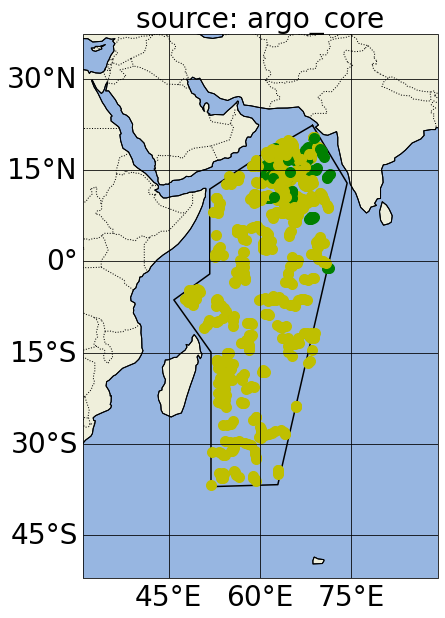

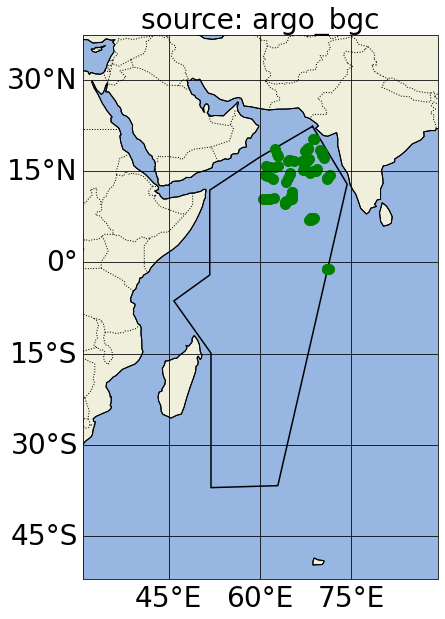

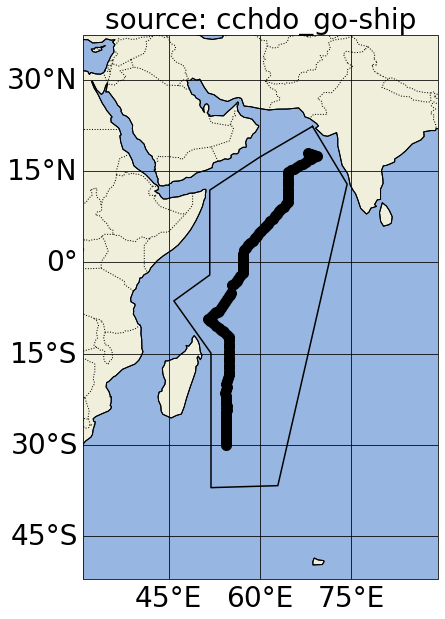

In [5]:
source_all = ['argo_core','argo_bgc','cchdo_go-ship']
for isource in source_all:
    bfr_df = get_data_for_timeRange(startDate=startDate,endDate=endDate, \
                                url_prefix=URL_PREFIX+'/profiles?', \
                                myAPIkey=API_KEY, \
                                source=isource, \
                                polygon=polygon, \
                                dt_tag='365d',writeFlag=True)
    if not bfr_df.empty:
        bfr_info = get_info_from_df(df=bfr_df,info_to_store=info_to_store)
        ###### let's plot the polygon and the profile locations color coded by source
        set_map_and_plot_locations_withColor(lon=bfr_info['lon'],lat=bfr_info['lat'], \
                                     cols=bfr_info['cols_bySource'], \
                                     polygon_lon_lat_dict=polygon_lon_lat_dict)
        plt.title('source: ' + isource,fontsize=28)

Notice in the first map, we actually got both `argo_bgc` and `argo_core` when we asked for `argo_core`; this is because Argo floats typically collect core profiles and BGC profiles together, and such a profile will carry both source tags. If we strictly want profiles that only include `argo_core` variables (i.e. profiles that do not include `argo_bgc` variables), we can use Argovis' *negation search* in the `source` filter:

Number of items: 708
https://argovis-api.colorado.edu/profiles?&startDate=2018-04-27T00:00:00Z&endDate=2018-06-05T23:59:59Z&polygon=[[68.663028,22.389257],[59.970225,17.320499],[51.759644,11.897995],[51.759644,-2.067321],[45.853643,-6.331603],[51.9633,-14.929825],[51.9633,-37.056256],[62.960682,-36.730509],[74.365374,12.892522],[68.663028,22.389257]]&source=argo_core,~argo_bgc


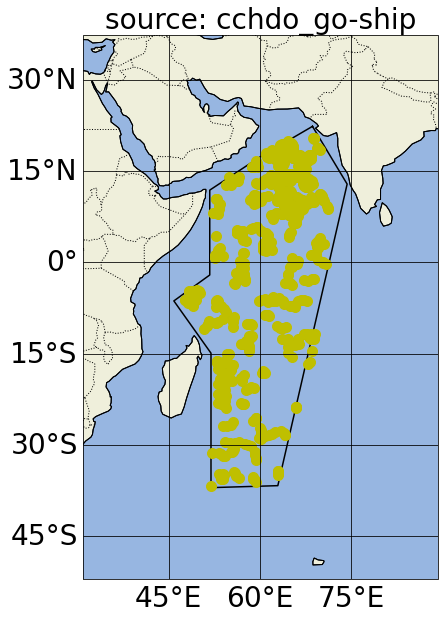

In [6]:
bfr_df = get_data_for_timeRange(startDate=startDate,endDate=endDate, \
                            url_prefix=URL_PREFIX+'/profiles?', \
                            myAPIkey=API_KEY, \
                            source='argo_core,~argo_bgc', \
                            polygon=polygon, \
                            dt_tag='365d',writeFlag=True)
if not bfr_df.empty:
    bfr_info = get_info_from_df(df=bfr_df,info_to_store=info_to_store)
    ###### let's plot the polygon and the profile locations color coded by source
    set_map_and_plot_locations_withColor(lon=bfr_info['lon'],lat=bfr_info['lat'], \
                                 cols=bfr_info['cols_bySource'], \
                                 polygon_lon_lat_dict=polygon_lon_lat_dict)
    plt.title('source: ' + isource,fontsize=28)

Now we have profiles that only include `argo_core` variables, as desired. Among these profiles, there may be `argo_deep` profiles, if applicable for the region. If we want an account of the different types of Argo profiles in a region, we can iterate through these source parameters: 

 - `'argo_core,~argo_bgc,~argo_deep'` 
 - `'argo_bgc,~argo_deep'` 
 - `'argo_deep,~argo_bgc'` 
 - `'argo_bgc,argo_deep'`
 
Counting the profiles for each query, we would know how many profiles only have core variables (exclusive of deep and BGC variables), how many profiles have BGC variables exclusive of deep measurements, how many profiles have deep measurements exclusive of BGC variables, and how many profiles have both BGC variables and deep measurements, respectively. We note that `argo_deep` profiles are tagged as any profile with levels deeper than 2500 dbar, and therefore will also also carry an `argo_core` or `argo_bgc` source tag. If we want to check for edge cases when a BGC profile file is available yet a core file is not, we can use the parameter `'argo_bgc,~argo_core'` (this should not happen).

### Searching by available data

We often only want profiles that have data of interest. Argovis features the ability to perform exactly this type of search, providing metadata and data only for profiles with the measurements we need. Let's look for profiles in our region of interest that have dissolved oxygen and pressure measurements, by using the `data` filter. Also note adding `metadata-only` to the filter list tells Argovis to look for profiles that have the data listed, but only actually return the corresponding metadata for those profiles:

Number of items: 204
https://argovis-api.colorado.edu/profiles?&startDate=2018-04-27T00:00:00Z&endDate=2018-06-05T23:59:59Z&polygon=[[68.663028,22.389257],[59.970225,17.320499],[51.759644,11.897995],[51.759644,-2.067321],[45.853643,-6.331603],[51.9633,-14.929825],[51.9633,-37.056256],[62.960682,-36.730509],[74.365374,12.892522],[68.663028,22.389257]]&data=doxy,pres,metadata-only


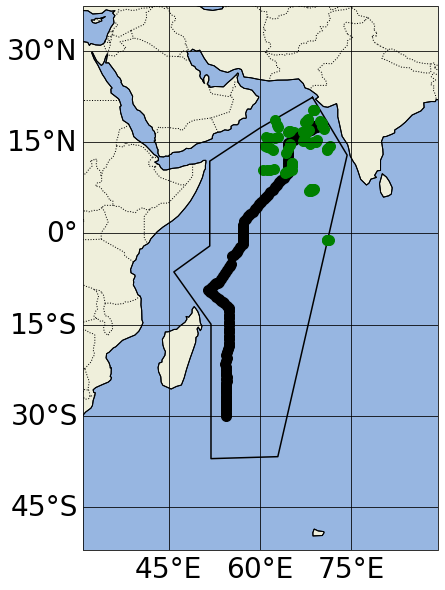

In [7]:
df = get_data_for_timeRange(startDate=startDate,endDate=endDate, \
                                url_prefix=URL_PREFIX+'/profiles?', \
                                myAPIkey=API_KEY, \
                                data='doxy,pres,metadata-only', \
                                polygon=polygon, \
                                dt_tag='100d',writeFlag=True)
if not df.empty:
    if 'df_all' in locals():
        df_all = pd.concat([df_all,df],ignore_index=True)
    else:
        df_all = df
            
# store some info
info_d_reg = get_info_from_df(df=df_all,info_to_store=info_to_store)

# delete df_all
del df_all

###### let's plot the polygon and profile locations color coded by source
set_map_and_plot_locations_withColor(lon=info_d_reg['lon'],lat=info_d_reg['lat'], \
                                     cols=info_d_reg['cols_bySource'], \
                                     polygon_lon_lat_dict=polygon_lon_lat_dict)

We can perform a similar search, this time demanding data be only from a particular WOCE line with the `woceline=` filter:

Number of items: 124
https://argovis-api.colorado.edu/profiles?&startDate=2018-04-27T00:00:00Z&endDate=2018-06-05T23:59:59Z&data=doxy,pres,metadata-only&woceline=I07N


Text(0.5, 1.0, 'I07N')

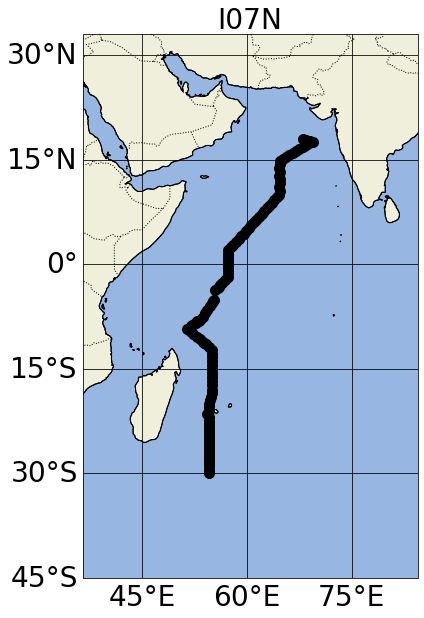

In [8]:
if 'df_d1' in locals():
    del df_d1

df = get_data_for_timeRange(startDate=startDate,endDate=endDate, \
                                url_prefix=URL_PREFIX+'/profiles?', \
                                myAPIkey=API_KEY, \
                                data='doxy,pres,metadata-only', \
                                woceline='I07N', \
                                dt_tag='365d',writeFlag=True)
if not df.empty:
    if 'df_d1' in locals():
        df_d1 = pd.concat([df_d1,df],ignore_index=True)
    else:
        df_d1 = df
# store some info
info_d1 = get_info_from_df(df=df_d1,info_to_store=info_to_store)

font = {'weight' : 'normal',
        'size'   : 24}

plt.rc('font', **font)
set_map_and_plot_locations_withColor(lon=info_d1['lon'],lat=info_d1['lat'], \
                                     cols=info_d1['cols_bySource'], \
                                     polygon_lon_lat_dict=[])
plt.title('I07N',fontsize=28)

### Proximity search

Now that we've identified some information from this woceline of interest, we can use Argovis' proximity search to find nearby Argo profiles, via the `radius` and `center` pair of query parameters, which together search for profiles within a given distance of a centerpoint. Here we also use the `metadata-only` flag to `data`, so we get profiles that contain `pres` and `doxy`, but for now only actually download their metadata:

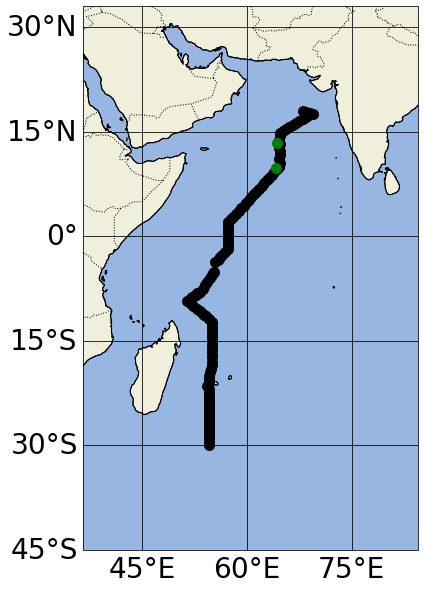

In [9]:
delta_days = 3.5

if 'df_d2' in locals():
    del df_d2

lst_id_pairs_d1 = []
lst_id_pairs_d2 = []

for i in np.arange(0,len(info_d1['lon'])):
    time.sleep(.2)
    d = get_data_for_timeRange(startDate=(datetime.strptime(info_d1['date'][i],'%Y-%m-%dT%H:%M:%SZ')- \
                                          timedelta(days=delta_days)).strftime('%Y-%m-%dT%H:%M:%SZ'),
                               endDate=(datetime.strptime(info_d1['date'][i],'%Y-%m-%dT%H:%M:%SZ')+ \
                                          timedelta(days=delta_days)).strftime('%Y-%m-%dT%H:%M:%SZ'), \
                               myAPIkey=API_KEY, \
                               center=str(info_d1['lon'][i])+','+str(info_d1['lat'][i]), \
                               radius_km='50', \
                               url_prefix=URL_PREFIX+'/profiles?', \
                               data='pres,doxy,metadata-only', \
                               source='argo_core', \
                               dt_tag='365d',writeFlag=False)
    if not d.empty:
        #info_d2 = {**info_d2, **get_info_from_df(df=d,info_to_store=info_to_store)}
        #list_d2 = list_d2 + [d]
        if 'df_d2' in locals():
            df_d2 = pd.concat([df_d2,d],ignore_index=True)
        else:
            df_d2 = d
        lst_id_pairs_d2.append(d['_id'].tolist())
        lst_id_pairs_d1.append(info_d1['ids'][i])

info_d2=get_info_from_df(df=df_d2,info_to_store=info_to_store)

###### let's plot the profile locations color coded by source
set_map_and_plot_locations_withColor(lon=info_d1['lon']+info_d2['lon'],lat=info_d1['lat']+info_d2['lat'], \
                                     cols=info_d1['cols_bySource']+info_d2['cols_bySource'])

Finally, now that we've found Argo and GO-SHIP profiles that both measure dissolved oxygen, we can download the measurements of interest, plot the two and compare:

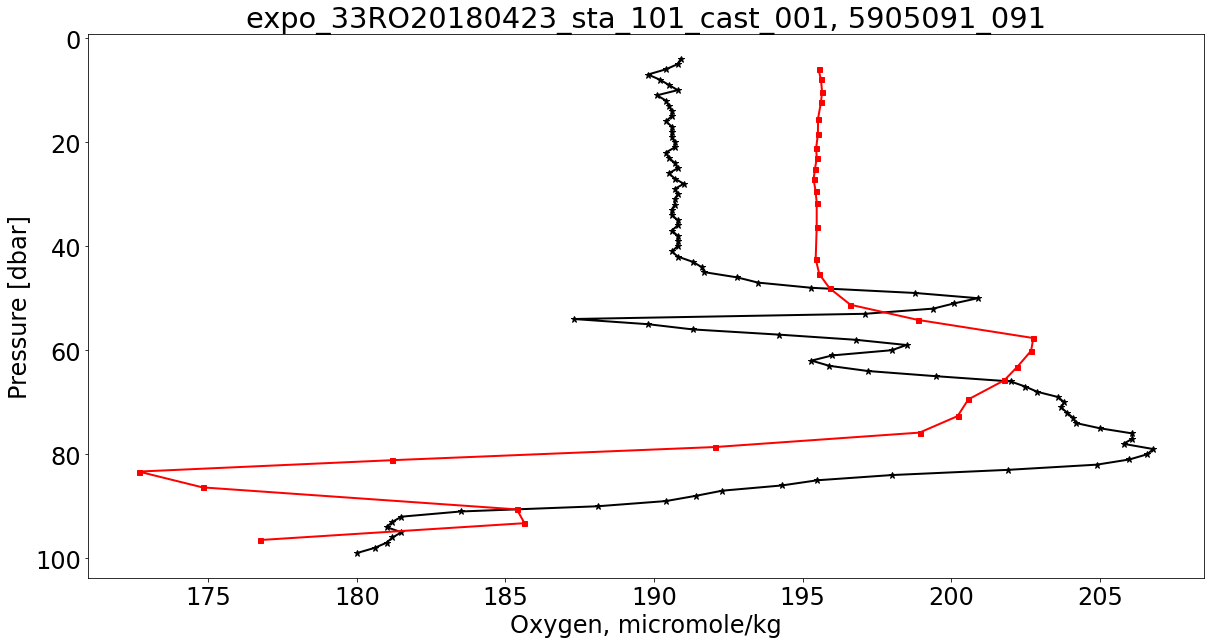

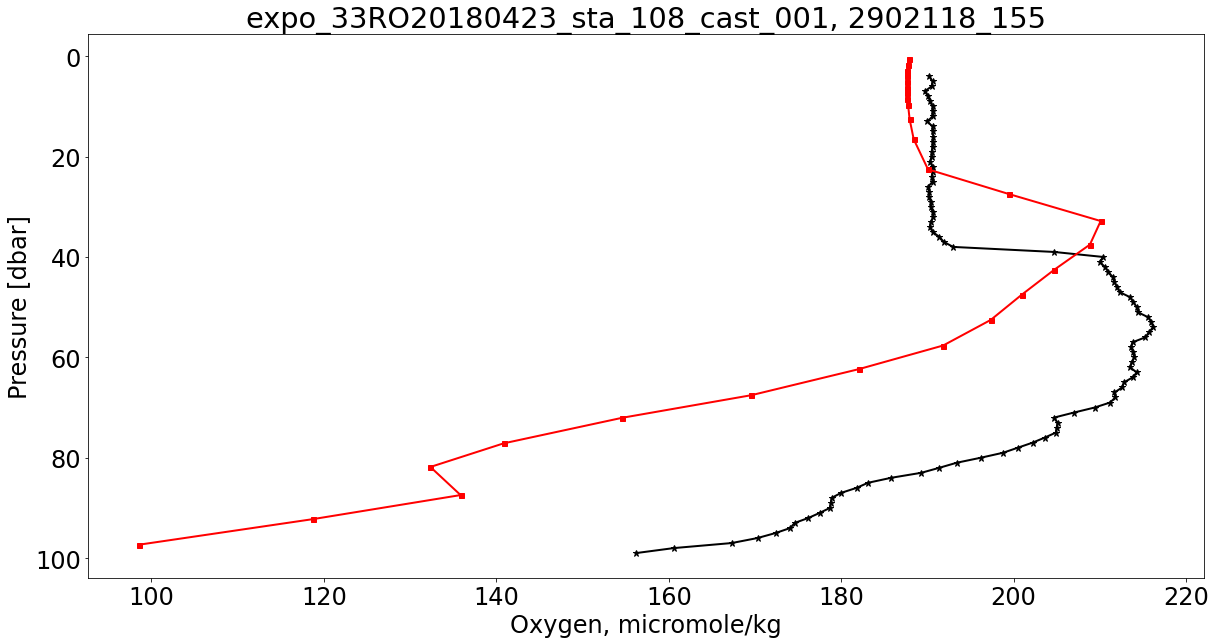

In [10]:
font = {'weight' : 'normal',
        'size'   : 24}

plt.rc('font', **font)

col_d1 = 'k'
col_d2 = 'r'

var_d1 = 'doxy' 
var_d2 = 'doxy'

mrk_sz1 = 7
mrk_sz2 = 5

mrk_type1 = '*'
mrk_type2 = 's'

presRange ='0,100'

for i in np.arange(0,len(lst_id_pairs_d1),1):
    ids_bfr1 = lst_id_pairs_d1[i]
    ids_bfr2 = lst_id_pairs_d2[i]
    if isinstance(ids_bfr1,str):
        ids_bfr1 = [ids_bfr1]
    if isinstance(ids_bfr2,str):
        ids_bfr2 = [ids_bfr2]
        
    fig = plt.figure(figsize=(20,10))
    fig_close = True
    
    if 'bfr_title' in locals():
        del bfr_title
        
    # plot 
    for isource in [1,2]:
        if 'ids_bfr' in locals():
            del ids_bfr
        ids_bfr = eval('ids_bfr'+str(isource))
        # print(ids_bfr)
        for j in ids_bfr:
            bfr = pd.DataFrame(get_data_from_url(url=URL_PREFIX+'/profiles?&data='+var_d2+',pres&id='+j+'&presRange='+presRange,\
                                                 myAPIkey=API_KEY,writeFlag=False))
            
            if 'bfr_df' in locals():
                del bfr_df

            for j_df in bfr['data']:
                if not 'bfr_df' in locals():
                    bfr_df = pd.DataFrame(j_df)
                else:
                    bfr_df = pd.concat([bfr_df,j_df],ignore_index=True)
            if eval('var_d'+str(isource)) in bfr_df.keys():
                bfr_df2plt = bfr_df[bfr_df.eval(eval('var_d'+str(isource))).notnull()]
                plt.plot(bfr_df2plt[eval('var_d'+str(isource))],bfr_df2plt['pres'], \
                         marker=eval('mrk_type'+str(isource)),markersize=eval('mrk_sz'+str(isource)),color=eval('col_d'+str(isource)),linewidth=2)
                if isource ==2:
                    fig_close = False
                if not 'bfr_title' in locals():
                    bfr_title = j # eval('var_d'+str(isource))
                else:
                    bfr_title = bfr_title + ', ' + j #eval('var_d'+str(isource))
    plt.gca().invert_yaxis()
    plt.title(bfr_title)
    plt.xlabel(set_ax_label(var_d1))
    plt.ylabel(set_ax_label('pres'))
    if fig_close:
        plt.close(fig)

## QC filtering

Argovis offers QC flags for data whenever available as elements in a profile's `data` array, but by default does not make any filtering decisions based on those flags. This example will show you how to filter your data by corresponding QC.

See ref. table 2 in section 4.1 of http://www.argodatamgt.org/content/download/15699/102401/file/argo-quality-control-manual-version2.8.pdf for a description of Argo QC flag interpretations.

First, let's get some data that has a couple of bad temperature measurements. Be sure to also ask for the QC variable `temp_argoqc` in your `data` query:

In [11]:
url = create_url(URL_PREFIX+'/profiles?', profile_id='3900321_108', data='pres,temp,temp_argoqc')
profile = get_data_from_url(url,API_KEY)[0]

Lets's see what this temperature profile looks like in a simple plot that colors points by QC level:

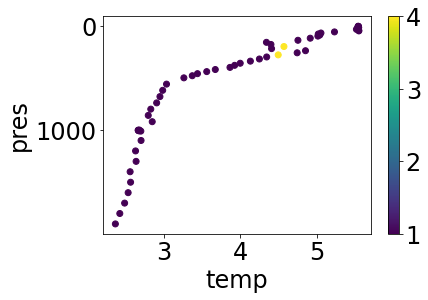

In [12]:
simple_plot(profile, 'temp', 'temp_argoqc')

As noted, there are a couple of levels with QC > 1, which we might not want. Let's filter those off so we can be completely confident in the data we're using with another simple masking function, and then plot the result:

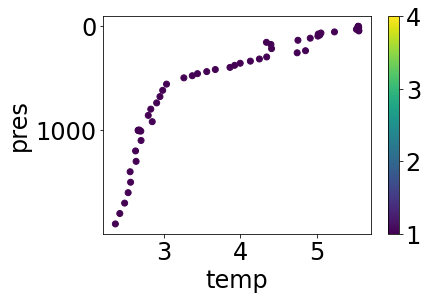

In [13]:
mp = mask_QC(profile, 'temp', [1])
simple_plot(mp, 'temp', 'temp_argoqc')

The offending levels have been suppressed, leaving us with only top-quality data. For the curious, have a look at the definition of `mask_QC`; an important design pattern illustrated there is that the function both takes and returns a dictionary that matches the JSON schema specification of an Argovis profile object; therefore, this function can be safely combined with other functions with a similar signature in a profile processing pipeline.

`mask_QC` provides fine-grained control of QC filtering one variable at a time, but we can also use the convenience function `qc` to quickly scrub all the data in a profile. As a prerequisite, we must request QC data to go with every data variable; Argo QC data for variable `x` is always found in `x_argoqc`, while CCHDO QC is marked `x_woceqc`.

In [14]:
url = create_url(URL_PREFIX+'/profiles?', profile_id='2902115_144', data='pres,pres_argoqc,chla,chla_argoqc,temp_sfile,temp_sfile_argoqc')
profile = get_data_from_url(url,API_KEY)[0]

Let's have a look at the BGC temperature and chlorophyll as they appear without QC filtering:

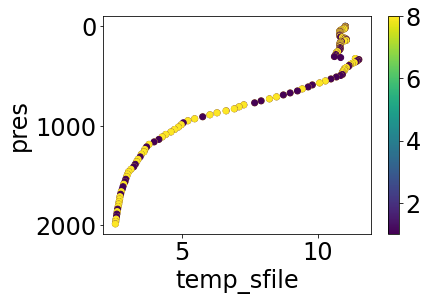

In [15]:
simple_plot(profile, 'temp_sfile', 'temp_sfile_argoqc')

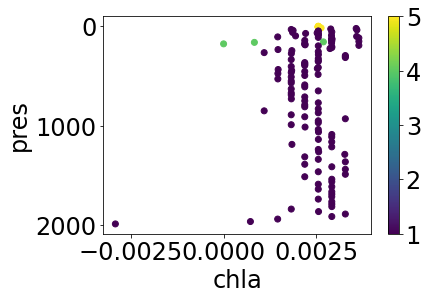

In [16]:
simple_plot(profile, 'chla', 'chla_argoqc')

Apply the default cleaning to quickly tidy up, and replot:

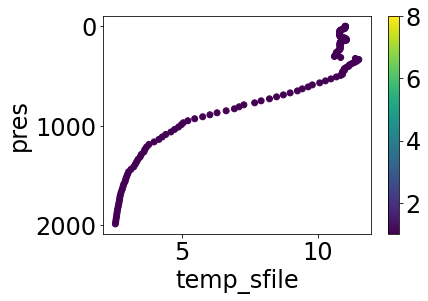

In [17]:
cleaned = qc(profile)
simple_plot(cleaned, 'temp_sfile', 'temp_sfile_argoqc')

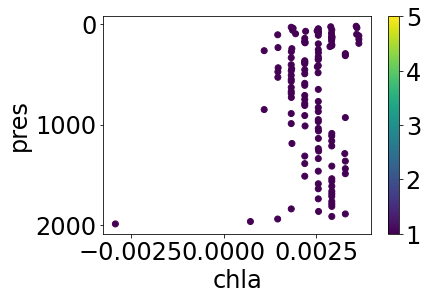

In [18]:
simple_plot(cleaned, 'chla', 'chla_argoqc')

This worked quickly and easily, but if we look again at the original plots of this profile, most of the flagged levels for BGC temperature are QC==8, which indicates interpolated, and not necessarily bad, data. We can provide our cleaning function with custom levels to keep more points if desired:

In [19]:
partially_cleaned = qc(profile,[('temp_sfile',[1,8])])

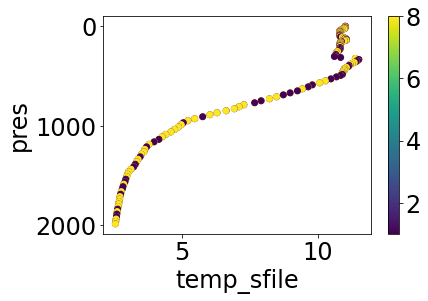

In [20]:
simple_plot(partially_cleaned, 'temp_sfile', 'temp_sfile_argoqc')

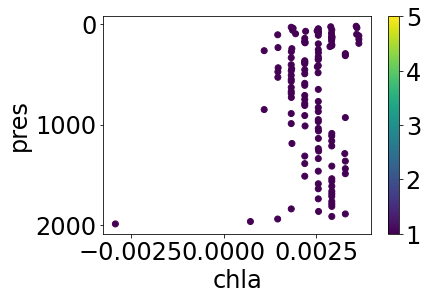

In [21]:
simple_plot(partially_cleaned, 'chla', 'chla_argoqc')

We get the interpolated temperature measurements, but none of the high-flag chlorophyll.

## Interpolation

At times we may wish to interpolate data to a set of standard levels, rather than accept whatever pressure levels a profile presents. The convenience function `interpolate` performs this for us. Let's begin by fetching a profile as usual, and remember what its temperature plot looks like:

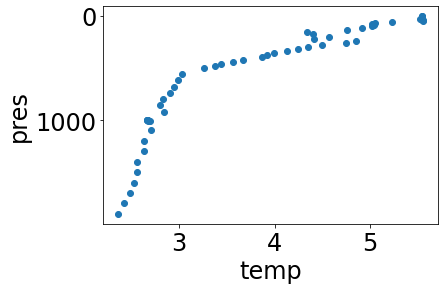

In [22]:
url = create_url(URL_PREFIX+'/profiles?', profile_id='3900321_108', data='pres,temp,temp_argoqc')
profile = get_data_from_url(url,API_KEY)[0]
simple_plot(profile, 'temp')

Use the `interpolate` function to interpolate every data variable in the profile to a set of levels, every 100 meters from 0 to 2000:

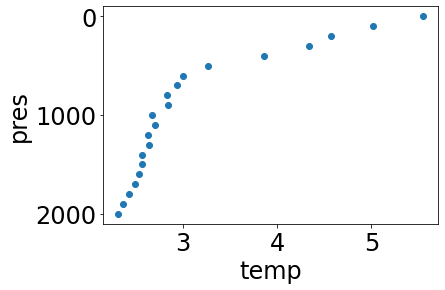

In [23]:
interpolated_profile = interpolate(profile, list(range(0,2001))[0::100])
simple_plot(interpolated_profile, 'temp')

Note a few facts about interpolated profiles:
 - All QC information is dropped, as there is no meaningful way to interpolate QC flags. Therefore, it's best to do any QC cleaning you desire *before* interpolation.
 - profile.data_warnings will include the flag `data_interpolated` to indicate a profile's data has been interpolated in this fashion.
 - By default, pchip intepolation is performed.
 
In addition to pchip, linear interpolation and nearest-neighbor are also available:

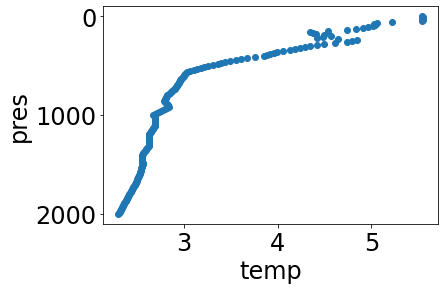

In [24]:
linear_interpolated_profile = interpolate(profile, list(range(0,2001))[0::10], method='linear')
simple_plot(linear_interpolated_profile, 'temp')

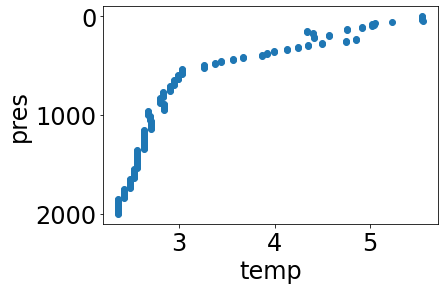

In [25]:
nn_interpolated_profile = interpolate(profile, list(range(0,2001))[0::10], method='nearest')
simple_plot(nn_interpolated_profile, 'temp')

# References

TBD